This file will be the finished version of the Radiation_workshop.ipynb

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy as sp
from scipy import optimize
import pandas as pd
from os import listdir
from os.path import isfile, join
from datetime import datetime
from scipy.stats import linregress

In [2]:
# We are going to setup the files, the line, and the wavelength here

mypath = "OTDR data/"
wl_chosen = 1310
line_chosen = 3
scan_length = 150
scan_time = 10

# Acquire all of the filenames
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))][:-2] # This is because there are other disturbing file
print(onlyfiles)

['Fiber_Meas_OTDR_2022-06-01_16-32-14_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-32-42_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-35-20_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-35-49_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-38-28_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_16-38-56_Line03_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-15-17_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-15-50_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-18-49_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-19-21_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-22-16_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_18-22-47_Line03_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-56-26_Line01_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-56-58_Line03_1310nm.txt', 'Fiber_Meas_OTDR_2022-06-01_19-59-49_Line01_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20-00-21_Line03_1550nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20-03-13_Line01_1625nm.txt', 'Fiber_Meas_OTDR_2022-06-01_20

In [3]:
# Make a function to extract information from the names.
def extract_info(fname):
    _,_,_, date_raw, time_raw, line_raw, wl_raw = fname.split("_")
    combined_time = date_raw + '_' + time_raw
    datetime_obj = datetime.strptime(combined_time, "%Y-%m-%d_%H-%M-%S")
    return datetime_obj, int(line_raw[-2:]), int(wl_raw[:4])

In [4]:
# make a function to create the filenames
def make_fname(datetime_obj, line, wl):
    return f'OTDR data/Fiber_Meas_OTDR_{datetime_obj.strftime("%Y-%m-%d_%H-%M-%S")}_Line0{line}_{wl}nm.txt'

In [5]:
time_array = []

for fname in onlyfiles:
    # Extract the infos
    time_ext, line_ext, wl_ext = extract_info(fname)
    
    if (wl_ext == wl_chosen and line_ext == line_chosen):
        time_array.append(time_ext)
        
len_time = len(time_array)        
            

Here we calculate the duration instead of the absolute time

In [6]:
relative_time_array = np.zeros_like(time_array)
initial_time = time_array[0]
for i in range(len_time):
    relative_time_array[i] = (time_array[i] - initial_time).total_seconds()/3600 # Calculate in hours

Take line samples

In [7]:
# Take 5 sample lines
sample_line1 = np.loadtxt(make_fname(time_array[0], line_chosen, wl_chosen), skiprows=13)
sample_line2 = np.loadtxt(make_fname(time_array[len_time//4], line_chosen, wl_chosen), skiprows=13)
sample_line3 = np.loadtxt(make_fname(time_array[len_time//2], line_chosen, wl_chosen), skiprows=13)
sample_line4 = np.loadtxt(make_fname(time_array[3*(len_time//4)], line_chosen, wl_chosen), skiprows=13)
sample_line5 = np.loadtxt(make_fname(time_array[-1], line_chosen, wl_chosen), skiprows=13)

# Aggregate the data
sample_lines = np.array([sample_line1, sample_line2, sample_line3, sample_line4, sample_line5])

In [8]:
length_increment = scan_length/len(sample_line1-1)
print(f"length increment: {length_increment:.8f}, should match the file!!!")
length_array = np.linspace(0,scan_length,len(sample_line1))

length increment: 0.03996803, should match the file!!!


Now, we have to select which part of the trace we want to use for our calculation

In [9]:
min_pos = 43 # meters
max_pos = 70
min_idx = int(min_pos//length_increment)
max_idx = int(max_pos//length_increment)


Now we are going to plot the traces

length: 27.03 meters


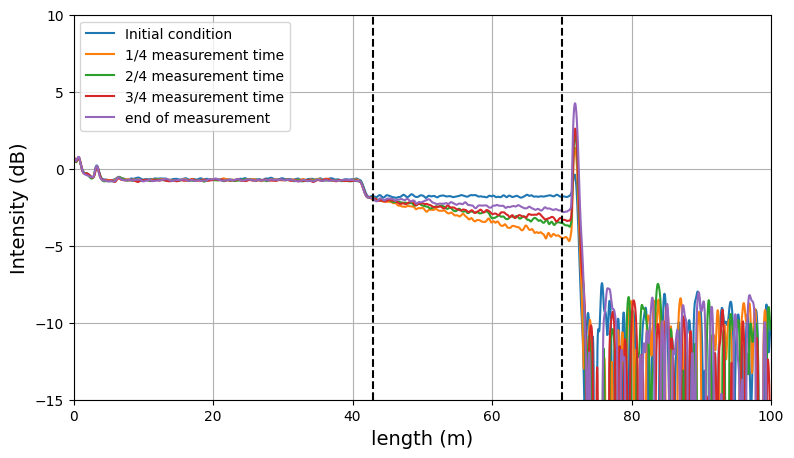

In [10]:
fig, ax = plt.subplots(1,1,figsize = (9,5))
ax.plot(length_array, sample_line1, label = "Initial condition")
ax.plot(length_array, sample_line2, label = "1/4 measurement time")
ax.plot(length_array, sample_line3, label = "2/4 measurement time")
ax.plot(length_array, sample_line4, label = "3/4 measurement time")
ax.plot(length_array, sample_line5, label = "end of measurement")
ax.set_xlabel("length (m)", fontsize = 14)
ax.set_ylabel("Intensity (dB)", fontsize = 14)
ax.grid(True)
ax.set_xlim([0,100])
ax.set_ylim([-15, 10])
ax.axvline(min_idx*length_increment, color = 'black', linestyle = '--')
ax.axvline(max_idx*length_increment, color = 'black', linestyle = '--')
ax.legend()
plt.plot()
print(f"length: {(length_array[max_idx] - length_array[min_idx]):.2f} meters")

In [11]:
# Create the matrix the column is position, the row is time.
matrix = np.array([np.loadtxt(make_fname(time_array[i],line_chosen, wl_chosen), skiprows=13) for i in range(len_time)])

[]

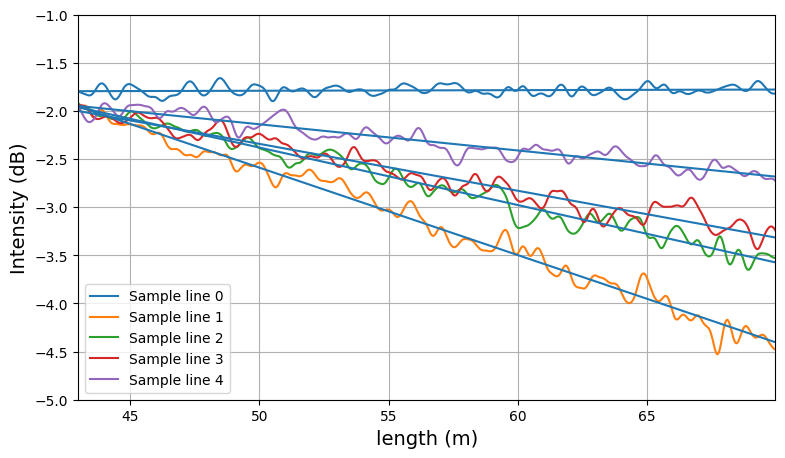

In [35]:
# Check the fitting for the sample lines

sample_length = length_array[min_idx:max_idx]
slope_array = np.zeros(5)
intercept_array = np.zeros(5)
for i in range(5):
    sample_intensities = sample_lines[i,min_idx:max_idx]
    reg_result = linregress(sample_length, sample_intensities)
    slope_array[i] = reg_result.slope
    intercept_array[i] = reg_result.intercept

fig_samp, ax_samp = plt.subplots(1,1,figsize = (9,5))
for i in range(5):
    ax_samp.plot(sample_length, sample_lines[i,min_idx:max_idx], label = f"Sample line {i}")
for i in range(5):
    ax_samp.axline((0,intercept_array[i]), slope = slope_array[i])
ax_samp.set_xlim((sample_length[0], sample_length[-1]))
ax_samp.set_ylim([-5,-1])
ax_samp.grid(True)
ax_samp.set_xlabel("length (m)", fontsize = 14)
ax_samp.set_ylabel("Intensity (dB)", fontsize = 14)
ax_samp.legend()
plt.plot()

If the fitting is ok, it is now time to calculate the whole TIA

In [13]:
gradients = np.zeros(len_time)
lengths = length_array[min_idx:max_idx]
for i in range(len_time):
    intensities = matrix[i, min_idx:max_idx]
    gradients[i] = linregress(lengths, intensities).slope
    
# Calculate the TIA
actual_TIA = gradients[0]-gradients

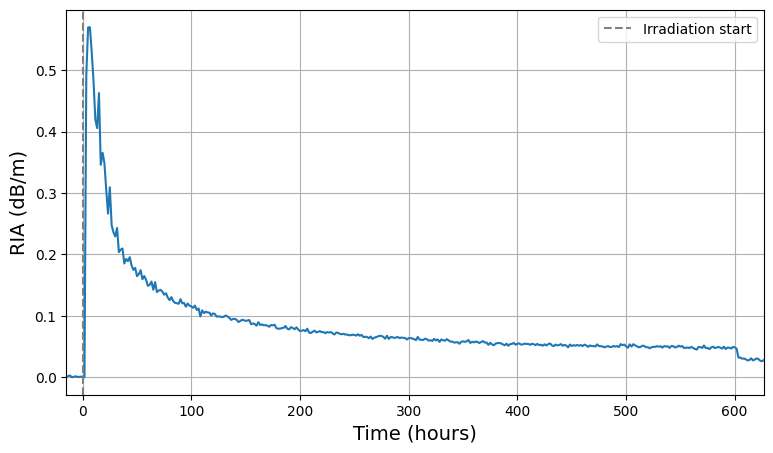

In [25]:
# In the plot, we have to mark when the irradiation actually starts!
Irr_start = 15 # hours

fig_TIA, ax_TIA = plt.subplots(1,1, figsize = (9,5))
ax_TIA.plot(relative_time_array-Irr_start, actual_TIA)
ax_TIA.axvline(0, linestyle = '--', color = 'grey', label = "Irradiation start")
ax_TIA.grid(True)
ax_TIA.set_xlabel("Time (hours)", fontsize = 14)
ax_TIA.set_ylabel("RIA (dB/m)", fontsize = 14)
ax_TIA.set_xlim((relative_time_array[0]-Irr_start, relative_time_array[-1]-Irr_start))
ax_TIA.legend()